This was originally a colab notebook, so all of the data importing is broken. The Particle Filtering code and graphs are all still valid though!

In [ ]:
import csv
import os
import time
import random
import sys
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.stats import norm, skewnorm, multivariate_normal

from math import cos, sin, pi
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HEIGHT_THRESHOLD = 0.0  # meters
GROUND_HEIGHT_THRESHOLD = -.4  # meters
DT = 0.1
X_LANDMARK = 5.  # meters
Y_LANDMARK = -5.  # meters
EARTH_RADIUS = 6.3781E6  # meters
N = 5
M = 3
S = 2
#HOW OFTEN TO RUN THE CORRECTION STEP 1=every iter 2=every other
f=1

In [ ]:
def save_data(data, filename):
    """Save data from dictionary to csv

    Parameters:
    filename (str)  -- the name of the csv log
    data (dict)     -- data to log
    """
    header = ["X", "Y", "Z", "Time Stamp", "Latitude", "Longitude",
              "Yaw", "Pitch", "Roll", "AccelX", "AccelY", "AccelZ"]
    f = open(filename, "w")
    num_rows = len(data["X"])
    for i in range(num_rows):
        for h in header:
            f.write(str(data[h][i]) + ",")

        f.write("\n")

    f.close()


def filter_data(data):
    """Filter lidar points based on height and duplicate time stamp

    Parameters:
    data (dict)             -- unfilterd data

    Returns:
    filtered_data (dict)    -- filtered data
    """

    # Remove data that is not above a height threshold to remove
    # ground measurements and remove data below a certain height
    # to remove outliers like random birds in the Linde Field (fuck you birds)
    filter_idx = [idx for idx, ele in enumerate(data["Z"])
                  if ele > GROUND_HEIGHT_THRESHOLD and ele < HEIGHT_THRESHOLD]

    filtered_data = {}
    for key in data.keys():
        filtered_data[key] = [data[key][i] for i in filter_idx]

    # Remove data that at the same time stamp
    ts = filtered_data["Time Stamp"]
    filter_idx = [idx for idx in range(1, len(ts)) if ts[idx] != ts[idx-1]]
    for key in data.keys():
        filtered_data[key] = [filtered_data[key][i] for i in filter_idx]

    return filtered_data


def convert_gps_to_xy(lat_gps, lon_gps, lat_origin, lon_origin):
    """Convert gps coordinates to cartesian with equirectangular projection

    Parameters:
    lat_gps     (float)    -- latitude coordinate
    lon_gps     (float)    -- longitude coordinate
    lat_origin  (float)    -- latitude coordinate of your chosen origin
    lon_origin  (float)    -- longitude coordinate of your chosen origin

    Returns:
    x_gps (float)          -- the converted x coordinate
    y_gps (float)          -- the converted y coordinate
    """
    x_gps = EARTH_RADIUS*(math.pi/180.)*(lon_gps - lon_origin)*math.cos((math.pi/180.)*lat_origin)
    y_gps = EARTH_RADIUS*(math.pi/180.)*(lat_gps - lat_origin)

    return x_gps, y_gps


def wrap_to_pi(angle):
    """Wrap angle data in radians to [-pi, pi]

    Parameters:
    angle (float)   -- unwrapped angle

    Returns:
    angle (float)   -- wrapped angle
    """
    while angle >= math.pi:
        angle -= 2*math.pi

    while angle <= -math.pi:
        angle += 2*math.pi
    return angle


def movingAverageFilter(a_x_imu, x):
  for i in range(len(a_x_imu)):
    upper = i+x
    lower = i-x

    if (upper >= len(a_x_imu)):
      upper = len(a_x_imu)-1

    if (lower < 0):
      lower = 0
    
    sum = 0
    for j in range(lower, upper):
      sum += a_x_imu[j]
    
    numPoints = upper - lower +1
    a_x_imu[x] = sum/numPoints

  return np.array(a_x_imu)


def preprocessYaw(yaw_lidar):
  yaw_lidar = np.array(yaw_lidar)
  dyaw = (np.insert(yaw_lidar, yaw_lidar.shape[0], 0) - np.insert(yaw_lidar, 0, 0))[1:-1]
  dyaw = [wrap_to_pi(x)/ 0.1 for x in dyaw]
  dyaw = np.insert(dyaw, 0, 0)
  return dyaw


def load_data(filename):
    """Load data from the csv log

    Parameters:
    filename (str)  -- the name of the csv log

    Returns:
    data (dict)     -- the logged data with data categories as keys
                       and values list of floats
    """
    is_filtered = False
    if os.path.isfile(filename + "_filtered.csv"):
        f = open(filename + "_filtered.csv")
        is_filtered = True
    else:
        f = open(filename + ".csv")

    file_reader = csv.reader(f, delimiter=',')

    # Load data into dictionary with headers as keys
    data = {}
    header = ["X", "Y", "Z", "Time Stamp", "Latitude", "Longitude",
              "Yaw", "Pitch", "Roll", "AccelX", "AccelY", "AccelZ"]
    for h in header:
        data[h] = []
    
    row_num = 0
    f_log = open("bad_data_log.txt", "w")
    for row in file_reader:
        for h, element in zip(header, row):
            # If got a bad value just use the previous value
            try:
                data[h].append(float(element))
            except ValueError:
                data[h].append(data[h][-1])
                f_log.write(str(row_num) + "\n")

        row_num += 1

    f.close()
    f_log.close()
    data['Yaw'] = [(360-x)*math.pi/180 for x in data['Yaw']]
    data["dYaw"] = preprocessYaw(data["Yaw"])
    data["avgAccelX"] = movingAverageFilter(data["AccelX"], 5)
    return data, is_filtered

In [ ]:
# Motion model
def propogate_state(p_t_prev, u_t):
    """Propogate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate
    u_t (np.array)       -- the current control input

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """

    p_bar_t = np.array([DT * p_t_prev[2],
                        DT * p_t_prev[3],
                        DT * u_t[0] * np.cos(p_t_prev[4]),
                        DT * u_t[0] * np.sin(p_t_prev[4]),
                        DT * u_t[1] + np.zeros(len(p_t_prev[2])),
                        np.zeros(len(p_t_prev[2]))])

    p_bar_t = p_bar_t + p_t_prev
    # p_bar_t[4] = wrap_to_pi(x_bar_t[4])
    p_bar_t[4] = (p_bar_t[4] + np.pi) % (2 * np.pi) - np.pi

    return p_bar_t

def lidarTransform(x_lidar,y_lidar,yaw):
    """ Transform all lidar position measurements into direct measurements of the robot’s x, y, yaw states """
    z_x = X_LANDMARK - (y_lidar*math.cos(yaw) + x_lidar*math.sin(yaw))
    z_y = Y_LANDMARK - (y_lidar*math.sin(yaw) - x_lidar*math.cos(yaw))
    z_yaw = wrap_to_pi(yaw)

    return np.array([z_x, z_y, z_yaw])
    
def calc_meas_prediction(x_bar_t):
    """Calculate predicted measurement based on the predicted state

    Parameters:
    x_bar_t (np.array)  -- the predicted state

    Returns:
    z_bar_t (np.array)  -- the predicted measurement
    """

    """STUDENT CODE START"""
    # zxt = 5 - (x_bar_t[1] * cos(x_bar_t[4]) + x_bar_t[0] * sin(x_bar_t[4]))
    # zyt = -5 - (x_bar_t[1] * sin(x_bar_t[4]) - x_bar_t[0] * cos(x_bar_t[4]))
    
    # ztt = x_bar_t[4]
    # z_bar_t = np.array([zxt,zyt,ztt])

    z_bar_t = np.array([x_bar_t[0], x_bar_t[1], x_bar_t[4]])

    """STUDENT CODE END"""

    return z_bar_t



# Helper function for calculating the probability P(z|x)
def sensor_reading_prob(z, p_list):
  z_bar_t = calc_meas_prediction(p_list)
  sensor_cov = np.diag(np.array([1,1,1]))

  # Transpose all the variables to make Scipy happy
  prob = multivariate_normal(z, sensor_cov).pdf(z_bar_t.T)

  assert prob.shape[0] == z_bar_t.shape[1], str(prob.shape) + " - " + str(z_bar_t.shape)
  return prob

# Prediction Step (vectorized)
def propagate_particles(p_list_t_prev, z_t, u_t, CONTROL_NOISE, skip, kidnap_strat):
  # Prediction step
  # Add noise to the control signal 
  u_t_sample = np.copy(u_t).reshape(-1, 1) * (1 + np.random.normal(0, CONTROL_NOISE, (len(u_t), len(p_list_t_prev[0]))))
  p_list_t = propogate_state(p_list_t_prev, u_t_sample)


    # Adding noise for kidnap
  if skip ==True and kidnap_strat =="noise":
    # Generate the noise particles
    N_noise = round(p_list_t_prev.shape[1])
    pos_x = np.random.uniform(0, 10, (1, N_noise))
    pos_y = np.random.uniform(0, -10, (1, N_noise))
    vel = np.random.normal(0, 0, (2, N_noise))
    yaw = np.random.uniform(0, 2*pi, (1, N_noise))
    prob = 0.1 * np.ones((1, N_noise)) / N_noise
    noise_particles = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)

    p_list_t = np.concatenate([p_list_t, noise_particles], axis=1)
    
  # Correction step
  w = sensor_reading_prob(z_t, p_list_t)
  w_sum = np.sum(w)
  p_list_t[5] = w / w_sum

  covariances = np.cov(p_list_t[0], p_list_t[1])

  # Calculate the new average
  x_avg_t = np.sum(p_list_t[0:2] * p_list_t[5].reshape(1,-1), axis=1)
  yaw_avg = np.sum(p_list_t[4] * p_list_t[5], axis = 0)

  return x_avg_t, p_list_t, covariances

# Prediction Step (element-wise)
# def propagate_particles(p_list_t_prev, z_t, u_t, CONTROL_NOISE):
#   p_list_t = []
#   w_sum = 0

#   for i, p_t_prev in enumerate(p_list_t_prev):
#     # Prediction step
#     # Add noise to the control signal
#     u_t_sample = np.copy(u_t)
#     u_t_sample *= (1+np.random.normal(0, CONTROL_NOISE, 2))
#     p_t = propogate_state(p_t_prev, u_t_sample)

#     # Correction step
#     w = sensor_reading_prob(z_t, p_t)
#     w_sum += w
#     p_t[5] = w
#     p_list_t.append(p_t)
#   # Normalize
#   p_list_t = np.array(p_list_t)
#   p_list_t[:, 5] /= w_sum


#   covariances = np.cov(p_list_t[:,0], p_list_t[:,1])
#   # Calculate the new average
#   x_avg_t = np.sum(p_list_t[:,0:2] * p_list_t[:, 5].reshape(-1,1), axis=0)
#   yaw_avg = np.sum(p_list_t[:,4] * p_list_t[:,5], axis = 0)

#   return x_avg_t, p_list_t, covariances

def resample(N, p_list_t):
  # Retrieve the number of particles
  
  
  # Transpose into matrix of horizontal vectors
  p_resampled_list_t = random.choices(p_list_t.T, weights=p_list_t[5], k=N)

  # Transpose back
  p_resampled_list_t = np.array(p_resampled_list_t).T

  return p_resampled_list_t


# plt.figure()
# xs = np.linspace(7, 3, 100)
# prob = [sensor_reading_prob(np.array([0.1, 0, 0]), np.array([x, -5, 0, 0, 0])) for x in xs]
# plt.plot(prob)


# Implementations


### Particle Filter

In [ ]:
def PF(N, CONTROL_NOISE, p_list_t_prev, skip = False, kidnap_strat=None):
  """Run a EKF on logged data from IMU and LiDAR moving in a box formation around a landmark"""

  #BOWEN'S PATH TO DATA
  filepath = "/content/drive/MyDrive/lab3 data/"
  filename = "2020_2_26__16_59_7"
  #data, is_filtered = load_data(filepath + filename)

  #MARCO/EVAN PATH TO DATA
  filepath = '/content/drive/Shareddrives/E205/Lab 3/Data/2020_2_26__16_59_7'
  data, is_filtered = load_data(filepath)


  # Save filtered data so don't have to process unfiltered data everytime
  if not is_filtered:
      data = filter_data(data)
      save_data(f_data, filepath+filename+"_filtered.csv")

  # Load data into variables
  x_lidar = data["X"]
  y_lidar = data["Y"]
  z_lidar = data["Z"]
  time_stamps = data["Time Stamp"]
  lat_gps = data["Latitude"]
  lon_gps = data["Longitude"]
  yaw_lidar = data["Yaw"]
  pitch_lidar = data["Pitch"]
  roll_lidar = data["Roll"]
  x_ddot = data["AccelX"]
  y_ddot = data["AccelY"]
  yaw_dot = data["dYaw"]
  x_avg_ddot = data["avgAccelX"]

  lat_origin = lat_gps[0]
  lon_origin = lon_gps[0]

  state_estimates = []
  covariance_estimates = np.empty((2,2, len(time_stamps)))
  # covariance_estimates = np.empty((N, N, len(time_stamps)))
  gps_estimates = []
  p_lists = []

  #time_stamps = time_stamps[0:200]
  #  Run filter over data
  for t, _ in tqdm(enumerate(time_stamps)):
    if (skip and (t > 225 and t < 425)):
      continue

    # Get control input
    u_t = np.array([x_avg_ddot[t], yaw_dot[t]])

    # Get measurement
    z_t = lidarTransform(x_lidar[t], y_lidar[t], yaw_lidar[t])

    # Propagate (prediction + correction)
    x_avg_t, p_list_t, covariances = propagate_particles(p_list_t_prev, z_t, u_t, CONTROL_NOISE, skip, kidnap_strat)
    
    
    # Resample
    p_resampled_list_t = resample(N, p_list_t)

    p_lists.append(p_resampled_list_t)
    # Iterate
    p_list_t_prev = p_resampled_list_t

    # Log Data
    state_estimates.append(x_avg_t)
    covariance_estimates[:, :, t] = covariances

    x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[t],
                                      lon_gps=lon_gps[t],
                                    lat_origin=lat_origin,
                                      lon_origin=lon_origin)
    gps_estimates.append(np.array([x_gps, y_gps]))
  
  state_estimates = np.array(state_estimates)
  gps_estimates = np.array(gps_estimates)

  return p_lists, state_estimates, gps_estimates



### Path Plotting

In [ ]:
def plotClouds(p_lists, state_estimates, gps_estimates, skip=False, figsize=(6,6), plot_style="line"):
  plt.close()
  fig, ax = plt.subplots(figsize=figsize)

  # Plotting the desired path
  if skip:
    perfect_x_1 = [0, 10]
    perfect_y_1 = [0, 0]
    ax.plot(perfect_x_1, perfect_y_1, "-x", label="Desired Path 1", color = "C1")

    perfect_x_1 = [10, 10]
    perfect_y_1 = [0, -10]
    ax.plot(perfect_x_1, perfect_y_1, "--", label="Kidnap Relocation", color = "C1")

    perfect_x_2 = [10, 0, 0]
    perfect_y_2 = [-10, -10, 0]
    ax.plot(perfect_x_2, perfect_y_2, "-x", label="Desired Path 2", color = "C1")
  else:
    perfect_x = [0,10, 10, 0, 0]
    perfect_y = [0, 0, -10, -10, 0]
    ax.plot(perfect_x, perfect_y, "-x", label="Desired Path", color = "C1")

  # Plotting the pylon
  ax.scatter([5], [-5], label="Pylon", color = "C4")

  # Plotting the GPS path
  ax.plot(gps_estimates[:,0], gps_estimates[:,1],  "C3-o", label="GPS")

  # Plotting the estimated path
  if plot_style == "line":
    ax.plot(state_estimates[:,0], state_estimates[:,1], 'C0-x', markersize=2, label="PF Estimate") 
  else:
    ax.plot(state_estimates[:,0], state_estimates[:,1], 'C0x', markersize=2, label="PF Estimate") 
  timestamps = np.arange(1, len(p_lists), 80)
  for t in timestamps:
    points = p_lists[t]
    x_vals = points[0]
    y_vals = points[1]
    probs = points[5]
    ax.scatter(x_vals, y_vals, color = "C0", s = (probs+0.1)*5, alpha=0.3)

  # Labeling
  ax.set_title("Particle Filter Localization Performance with N =" + str(p_lists[0].shape[1]) + (" (w/ Kidnap)" if skip else ""))
  ax.set_xlabel("X Position [m]")
  ax.set_xlim(-2,12)
  ax.set_ylabel("Y Position [m]")
  ax.set_ylim(-12,2)

  ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.5))


### Tracking Error Plotting

In [ ]:
def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

def euclidean_errors(state_estimates, skip=False):
  # The path with kidnap and without kidnap is different
  if skip:
    a = np.array([[0,  0],
                [10,  -10],
                [0, -10]])
    b = np.array([[ 10,  0],
                  [ 0,  -10],
                  [0, 0]])
  else:
    a = np.array([[0,  0],
                [10,  0],
                [10, -10],
                [0, -10]])
    b = np.array([[ 10,  0],
                  [ 10,  -10],
                  [ 0, -10],
                  [0, 0]])
  euclidean_error_list=[]

  # Calculate the errors
  for i in range(state_estimates.shape[0]):
    # print(state_estimates[0][i])
    euclidean_dists = lineseg_dists([state_estimates[i][0], state_estimates[i][1]], a, b)
    euclidean_error_list.append(min(euclidean_dists))

  return euclidean_error_list

def plotErrors(state_estimates, skip=False):
  plt.figure()
  errors = euclidean_errors(state_estimates, skip)
  print("Max Error", np.max(errors))
  print("Mean Error", np.mean(errors))
  print("Var Error", np.var(errors))
  times = np.arange(state_estimates.shape[0])/10
  plt.plot(times, errors, 'C0')
  # plt.title("Tracking Error (Euclidean) over Time")
  plt.ylabel("Euclidean Error(m)")
  plt.xlabel("Time(s)")

In [ ]:
# d1 = '/content/drive/Shareddrives/E205/Lab 3/Data/2020_2_26__17_21_59'
# d2 = '/content/drive/Shareddrives/E205/Lab 3/Data/2020_2_26__16_59_7'

# data, filtered = load_data(d1)

# Normal Runs (without kidnap)

### 100 Particles (Known Start)

815it [00:00, 1245.93it/s]


Max Error 4.595888419856963
Mean Error 0.8818070712660884
Var Error 1.3483864608513396


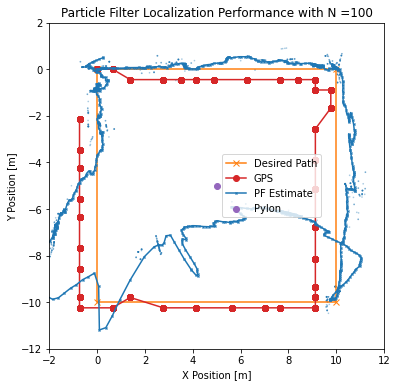

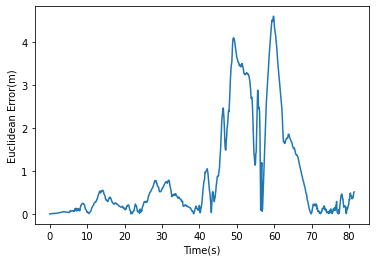

In [ ]:
# 100 particles
# Initialize particles
N = 100
skip = False
pos_x = np.random.normal(0, 0.01, (1, N))
pos_y = np.random.normal(0, 0.01, (1, N))
vel = np.random.normal(0, 0.01, (2, N))
yaw = np.random.normal(0, 0.01, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
plotErrors(state_estimates, skip)

### 1000 Particles (Known Start)

815it [00:02, 314.81it/s]


Max Error 0.7116811475267681
Mean Error 0.13599329381698336
Var Error 0.018174072301920027


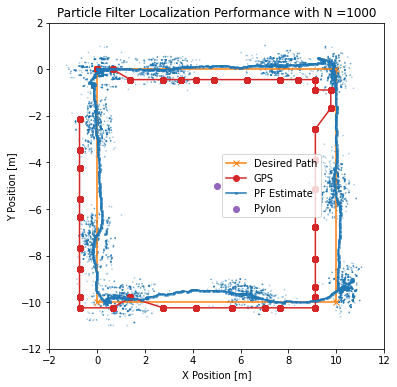

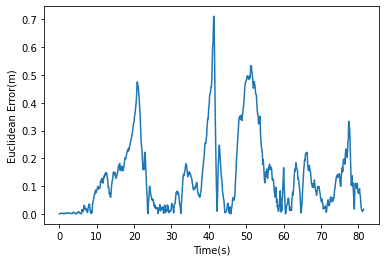

In [ ]:
# 100 particles
# Initialize particles
N = 1000
skip = False
pos_x = np.random.normal(0, 0.01, (1, N))
pos_y = np.random.normal(0, 0.01, (1, N))
vel = np.random.normal(0, 0.01, (2, N))
yaw = np.random.normal(0, 0.01, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
plotErrors(state_estimates, skip)

### 3000 Particles (Known Start)

815it [00:05, 148.35it/s]


Max Error 0.7418333162909434
Mean Error 0.12312923590649447
Var Error 0.011868040298005653


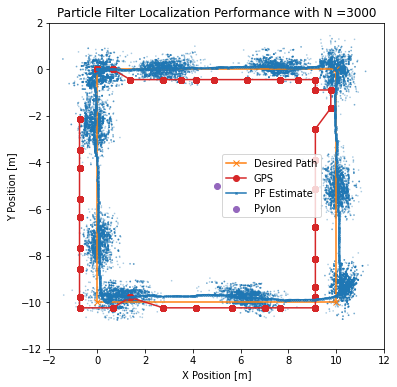

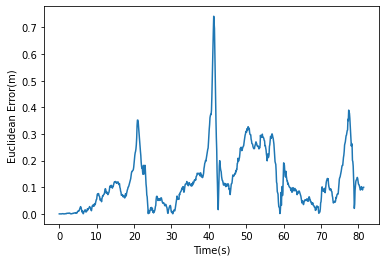

In [ ]:
# 100 particles
# Initialize particles
N = 3000
skip = False
pos_x = np.random.normal(0, 0.01, (1, N))
pos_y = np.random.normal(0, 0.01, (1, N))
vel = np.random.normal(0, 0.01, (2, N))
yaw = np.random.normal(0, 0.01, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
plotErrors(state_estimates, skip)

### 10000 Particles (Known Start)

In [ ]:
print(k_errors)
print(np.mean(k_errors))
print(np.mean(k_m_errors))
print(np.max(k_errors))
print(np.max(k_m_errors))
print(np.var(k_errors))
print(np.var(k_m_errors))

print(u_max_e)
print(np.mean(u_mean))
print(np.mean(k_m_errors))
print(np.max(k_errors))
print(np.max(k_m_errors))
print(np.var(k_errors))
print(np.var(k_m_errors))

[0.6709067785759366, 0.6879166978051998, 0.6782446720885442, 0.6882415908857311, 0.6835850054860302, 0.7075332956100127, 0.6930606852961034, 0.6762323136875796, 0.7021359926581567, 0.7018766634371705, 0.6673747513914545, 0.6917627361295562, 0.6638255922969787, 0.6518117143765743, 0.7162836634570837, 0.7253262521139305, 0.6282759164377616, 0.7151544857621559, 0.7067484199069458, 0.7104714293656578, 0.6919857180285884, 0.7085044000394003, 0.6799000161967861, 0.6673993638209801, 0.6917328734857087, 0.6839304721412454, 0.6811924005235088, 0.7226235150225513, 0.6476067252200757, 0.6937575721583009, 0.715863729634048]
0.6887504981625728
0.12851491083382044
0.7253262521139305
0.13809691095383894
0.0005051009419978914
2.229603825535793e-05
[0.7803969975155753, 1.202212265177072, 0.7840695281824364, 1.2881794474748036, 1.2432448373055855, 1.0383579328429844, 1.2924306484812556, 0.8099221627667159, 0.7616275828497283, 0.8457220907306023, 0.7724401653002848, 0.7618874407584441, 0.8448553710049719

815it [00:18, 44.69it/s]


Max Error 0.7085044000394003
Mean Error 0.13247794825178452
Var Error 0.013440454557219055


815it [00:18, 45.05it/s]


Max Error 0.6799000161967861
Mean Error 0.12176244245288817
Var Error 0.013130904478855414


815it [00:17, 45.88it/s]


Max Error 0.6673993638209801
Mean Error 0.12895579587817416
Var Error 0.012307532953088547


815it [00:17, 46.47it/s]


Max Error 0.6917328734857087
Mean Error 0.13634076967998657
Var Error 0.012452860979525499


815it [00:17, 46.40it/s]


Max Error 0.6839304721412454
Mean Error 0.12753878705113178
Var Error 0.013109846024811713


815it [00:17, 46.55it/s]


Max Error 0.6811924005235088
Mean Error 0.12867935188680746
Var Error 0.012306614303808442


815it [00:17, 46.35it/s]


Max Error 0.7226235150225513
Mean Error 0.12982164627794734
Var Error 0.012458373340238213


815it [00:17, 46.44it/s]


Max Error 0.6476067252200757
Mean Error 0.12698351199539665
Var Error 0.012550143496625176


815it [00:17, 46.45it/s]


Max Error 0.6937575721583009
Mean Error 0.12442228162429482
Var Error 0.012508302563525827


815it [00:17, 46.66it/s]


Max Error 0.715863729634048
Mean Error 0.12260974133539139
Var Error 0.011910637689355817


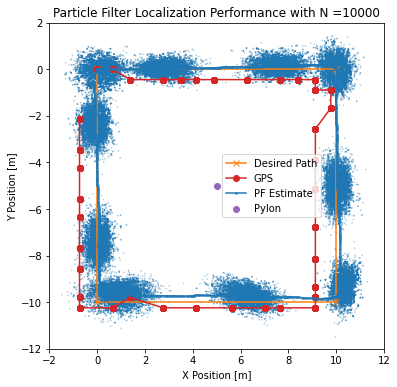

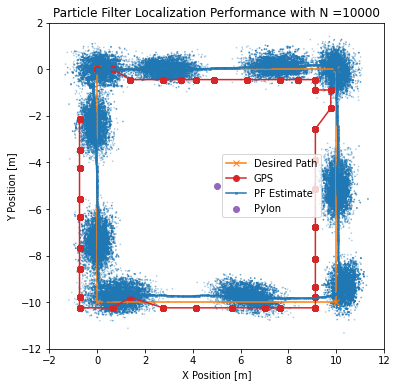

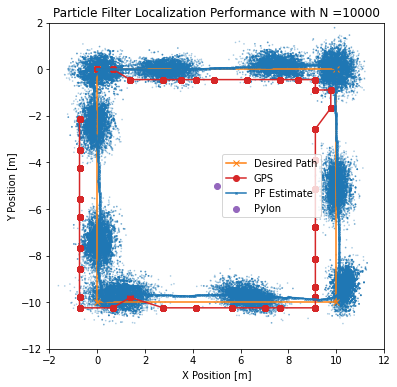

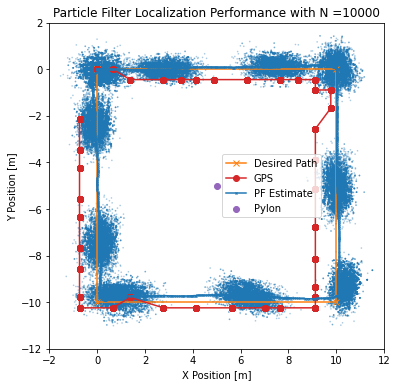

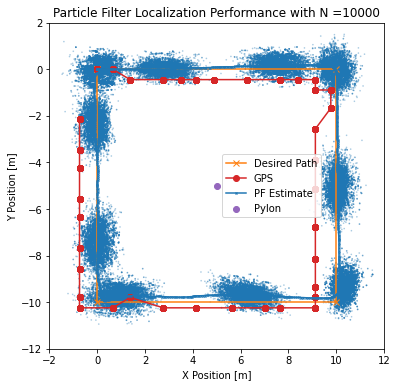

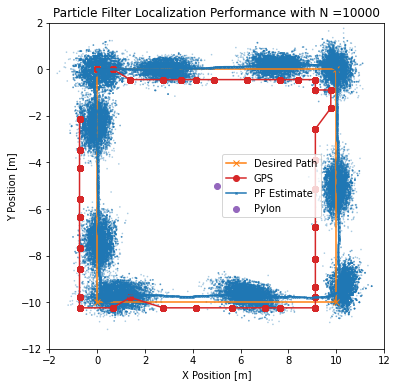

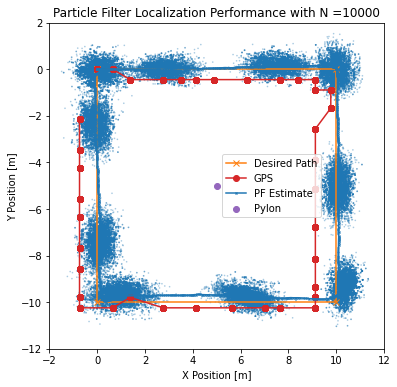

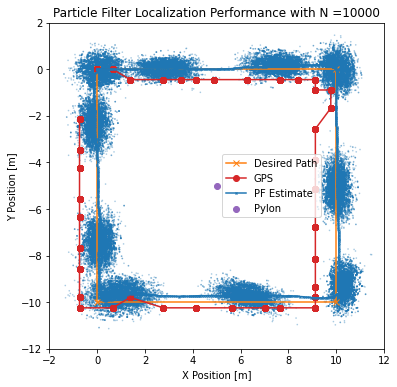

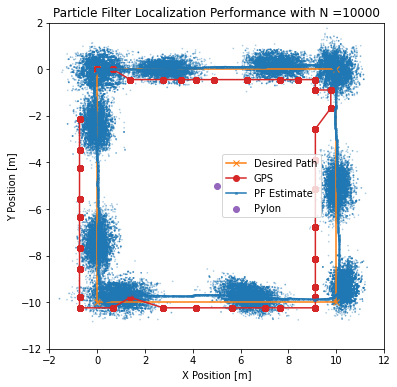

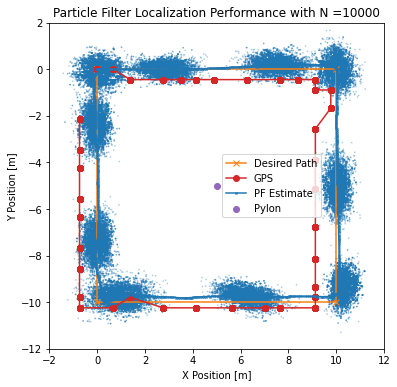

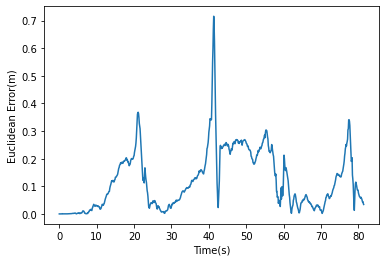

In [ ]:
# 100 particles
# Initialize particles
for x in range(0, 10):
  N = 10000
  skip = False
  pos_x = np.random.normal(0, 0.01, (1, N))
  pos_y = np.random.normal(0, 0.01, (1, N))
  vel = np.random.normal(0, 0.01, (2, N))
  yaw = np.random.normal(0, 0.01, (1, N))
  prob = np.ones((1, N)) / N
  p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
  # print(p_list_t_prev.shape)

  p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
  p_lists = np.array(p_lists)
  plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
  plotErrors(state_estimates, skip)
  errors = euclidean_errors(state_estimates, skip)
  k_errors.append(np.max(errors))
  k_m_errors.append(np.mean(errors))

### 100 Particles (Unknown Start)

815it [00:00, 1214.04it/s]


Max Error 2.1183726342410063
Mean Error 0.6265014506822727
Var Error 0.27810197160133254


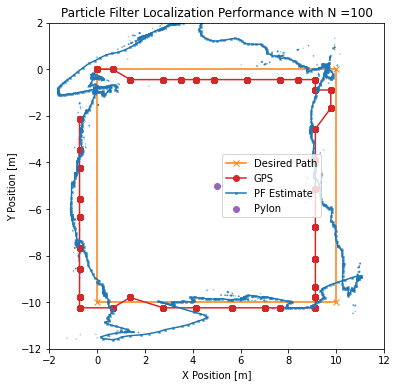

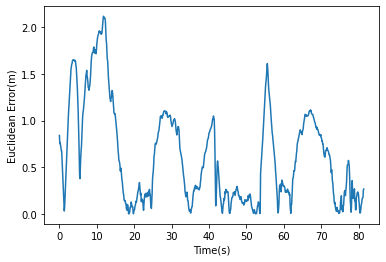

In [ ]:
# 100 particles
# Initialize particles
N = 100
skip = False
pos_x = np.random.uniform(0, 10, (1, N))
pos_y = np.random.uniform(0, -10, (1, N))
vel = np.random.normal(0, 1, (2, N))
yaw = np.random.uniform(0, 2*pi, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
plotErrors(state_estimates, skip)

### 1000 Particles (Unknown Start)

815it [00:02, 311.49it/s]


Max Error 0.873818764632583
Mean Error 0.16898275378085192
Var Error 0.02190562062002513


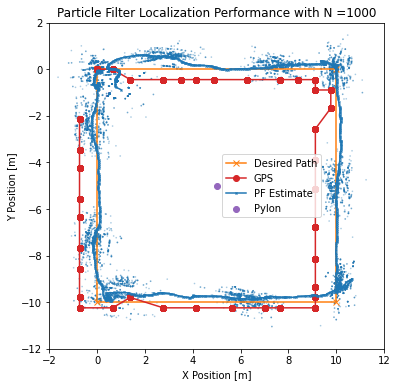

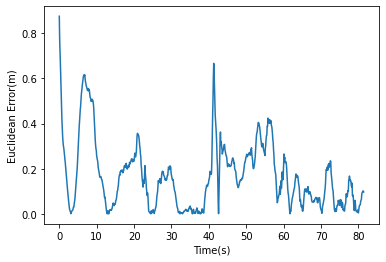

In [ ]:
# 100 particles
# Initialize particles
N = 1000
skip = False
pos_x = np.random.uniform(0, 10, (1, N))
pos_y = np.random.uniform(0, -10, (1, N))
vel = np.random.normal(0, 1, (2, N))
yaw = np.random.uniform(0, 2*pi, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
plotErrors(state_estimates, skip)

### 3000 Particles (Unknown Start)

815it [00:06, 121.86it/s]


Max Error 2.093090422255389
Mean Error 0.3466531597196032
Var Error 0.21539271854876105


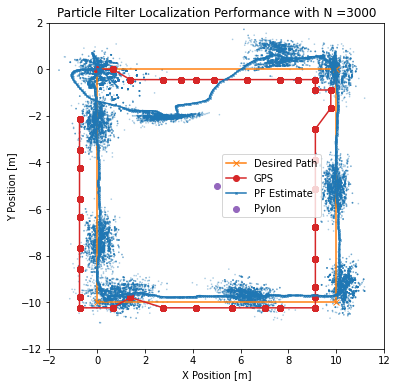

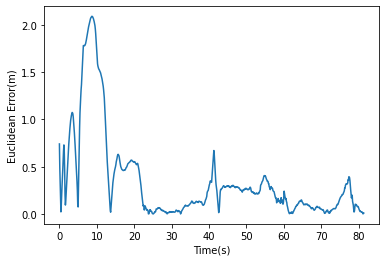

In [ ]:
# 3000 particles
# Initialize particles
N = 3000
skip = False
pos_x = np.random.uniform(0, 10, (1, N))
pos_y = np.random.uniform(0, -10, (1, N))
vel = np.random.normal(0, 1, (2, N))
yaw = np.random.uniform(0, 2*pi, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
plotErrors(state_estimates, skip)

###10000 Particles (Unknown Start)

In [ ]:
# 100 particles
# Initialize particles
for x in range(0, 10):
  N = 10000
  skip = False
  pos_x = np.random.uniform(0, 10, (1, N))
  pos_y = np.random.uniform(0, -10, (1, N))
  vel = np.random.normal(0, 1, (2, N))
  yaw = np.random.uniform(0, 2*pi, (1, N))
  prob = np.ones((1, N)) / N
  p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
  # print(p_list_t_prev.shape)

  p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip)
  p_lists = np.array(p_lists)
  plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
  plotErrors(state_estimates, skip)
  errors = euclidean_errors(state_estimates, skip)
  u_max_e.append(np.max(errors))
  u_mean_e.append(np.mean(errors))

815it [00:18, 44.81it/s]


Max Error 0.7948797881620325
Mean Error 0.16851560638356183
Var Error 0.017961594678991222


815it [00:18, 45.03it/s]


Max Error 0.9982104542376371
Mean Error 0.19263657673723794
Var Error 0.027594650860176952


815it [00:18, 44.89it/s]


Max Error 0.7407173949759138
Mean Error 0.1706255967159266
Var Error 0.01855467780531988


720it [00:16, 45.16it/s]

# Kidnapped Runs

### Without using any strategy (3000 particles)

815it [00:04, 179.67it/s]


Max Error 5.115879053791519
Mean Error 0.5380407616584528
Var Error 0.7580235327161408


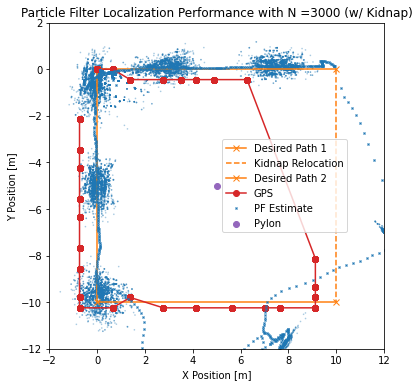

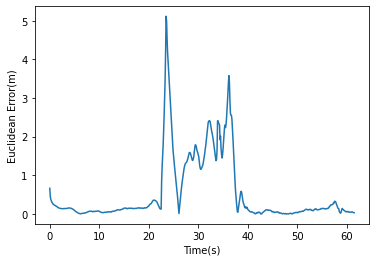

In [ ]:
# 3000 particles
# Initialize particles
N = 3000
skip = True
pos_x = np.random.uniform(0, 10, (1, N))
pos_y = np.random.uniform(0, -10, (1, N))
vel = np.random.normal(0, 0, (2, N))
yaw = np.random.uniform(0, 2*pi, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

# p_lists, state_estimates, gps_estimates = PF(N, 2, p_list_t_prev, skip)
# plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
# plotErrors(state_estimates, skip)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip, kidnap_strat=None)
plotClouds(p_lists, state_estimates, gps_estimates, skip, figsize=(6,6), plot_style="dot")   # Plotting the path
plotErrors(state_estimates, skip)

### Noise strategy (3000 particles)

815it [00:05, 143.97it/s]


Max Error 0.9013198034514716
Mean Error 0.17248723055579032
Var Error 0.02101192332726582


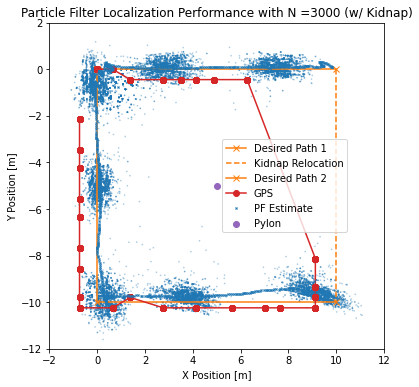

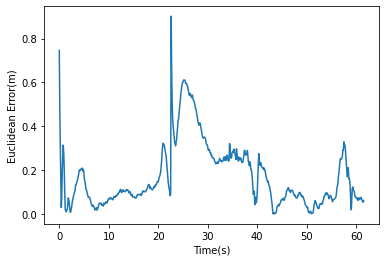

In [ ]:
# 1000 particles
# Initialize particles
N = 3000
skip = True
pos_x = np.random.uniform(0, 10, (1, N))
pos_y = np.random.uniform(0, -10, (1, N))
vel = np.random.normal(0, 1, (2, N))
yaw = np.random.uniform(0, 2*pi, (1, N))
prob = np.ones((1, N)) / N
p_list_t_prev = np.concatenate([pos_x, pos_y, vel, yaw, prob], axis=0)
# print(p_list_t_prev.shape)

# p_lists, state_estimates, gps_estimates = PF(N, 2, p_list_t_prev, skip)
# plotClouds(p_lists, state_estimates, gps_estimates, skip, (6,6))   # Plotting the path
# plotErrors(state_estimates, skip)

p_lists, state_estimates, gps_estimates = PF(N, 3, p_list_t_prev, skip, kidnap_strat="noise")
plotClouds(p_lists, state_estimates, gps_estimates, skip, figsize=(6,6), plot_style="dot")   # Plotting the path
plotErrors(state_estimates, skip)

array([ 9.12504137, -9.35078298])